# Learning a Variant Pathogencity Classifier

In [1441]:
# general stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
import itertools

# preprocessing stuff
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# learning, validation, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedShuffleSplit, cross_val_predict
from sklearn import svm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import pdist, squareform

plt.style.use('default')

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica Neue']

import warnings
warnings.filterwarnings('ignore') 

In [1252]:
def reset_plot_style():
    plt.style.use('default')
    mpl.rcParams['figure.dpi']= 300
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = ['Helvetica Neue']

## Importing variant data and cleaning up

In [74]:
full_data = pd.read_csv('featurized_variants.csv', index_col = 0)

In [75]:
# encoding the target variables:
# (likely) pathogenic --> 1
# (likely) benign --> 0

full_data.loc[full_data['clinical_significance'].str.contains(r'[p, P]athogenic'), 'clinical_significance_encoded'] = 1
full_data.loc[full_data['clinical_significance'].str.contains(r'[b, B]enign'), 'clinical_significance_encoded'] = 0

In [76]:
input_data = full_data[['polyphen2_score', 'COILS_maxdelta', 'structure_score', 'mrbayes_rate']]
output_data = (full_data['clinical_significance_encoded'])

In [77]:
len(input_data)

318

In [78]:
# total number of missing values
(input_data.isnull()).values.ravel().sum()

322

In [79]:
# total number of present values
(~input_data.isnull()).values.ravel().sum()

950

Around a quarter of all the values are missing, which is quite unfortunate.

In [80]:
input_data.isnull().values.sum(axis = 0)

array([  0, 108, 214,   0])

All of the missing data comes from the structure and COILS scores, which is not surprising. We will have to clean this up.

## Preprocessing

In [81]:
input_data = np.array(input_data)
output_data = np.array(output_data)

#### Imputing missing values

In [90]:
iter_imp = IterativeImputer(add_indicator = True, max_iter = 100)
iter_imp.fit(input_data)
imp_input_data = iter_imp.transform(input_data)

#### Scaling and centering

In [107]:
scaler = preprocessing.StandardScaler().fit(imp_input_data)
imp_scaled_input_data = scaler.transform(imp_input_data)

## Visualize

In [1464]:
pca = PCA(n_components = 2)
pca.fit(imp_scaled_input_data)
pca_input = pca.transform(imp_scaled_input_data)

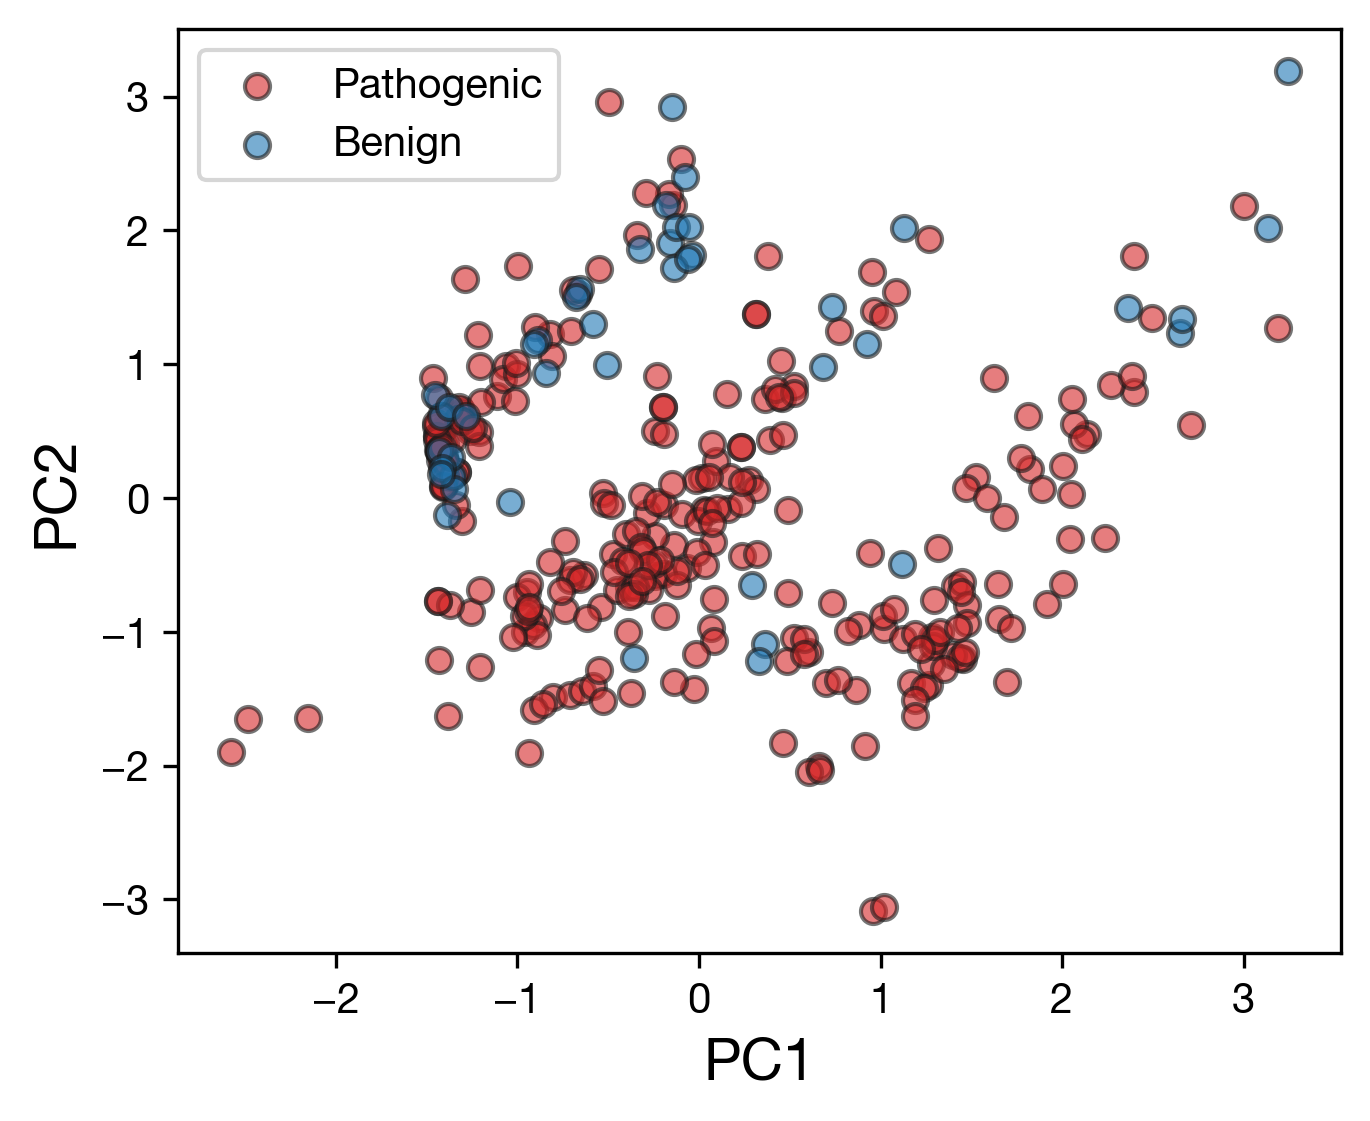

In [1471]:
fig, ax = plt.subplots(figsize = (5, 4))
ax.scatter(pca_input[output_data==1, 0], pca_input[output_data==1, 1], c = 'tab:red', alpha = 0.6, edgecolor = 'k')
ax.scatter(pca_input[output_data==0, 0], pca_input[output_data==0, 1], c = 'tab:blue', alpha = 0.6, edgecolor = 'k')
ax.set_xlabel('PC1', fontsize = 14)
ax.set_ylabel('PC2', fontsize = 14)
ax.legend(['Pathogenic', 'Benign']);

fig.savefig('pca_data.png')

## Learning an SVM classifier

In [408]:
exp = np.repeat(np.arange(-5, 0, 1, dtype = float), 4)
mul = np.tile(np.arange(1,10, 2), 4)
gamma = list(mul*(10**exp))
C = list(mul[::-1]*(10**(-exp-1)))

X_train, X_test, y_train, y_test = train_test_split(imp_scaled_input_data, 
                                                    output_data,
                                                    test_size = 0.4, 
                                                    shuffle = True, 
                                                    stratify = output_data)

tuned_parameters = {'C': C, 
                    'gamma': gamma, 
                    'kernel': ['rbf'], 
                    'class_weight':['balanced']}

optim_clf = GridSearchCV(
    svm.SVC(), tuned_parameters, cv = 5, scoring = 'precision', verbose = 0
)

optim_clf.fit(X_train, y_train)
print(optim_clf.best_params_)

y_true, y_pred = y_test, optim_clf.predict(X_test)
print(classification_report(y_true, y_pred))

{'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.05, 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.26      0.71      0.38        17
         1.0       0.94      0.69      0.80       111

    accuracy                           0.70       128
   macro avg       0.60      0.70      0.59       128
weighted avg       0.85      0.70      0.74       128



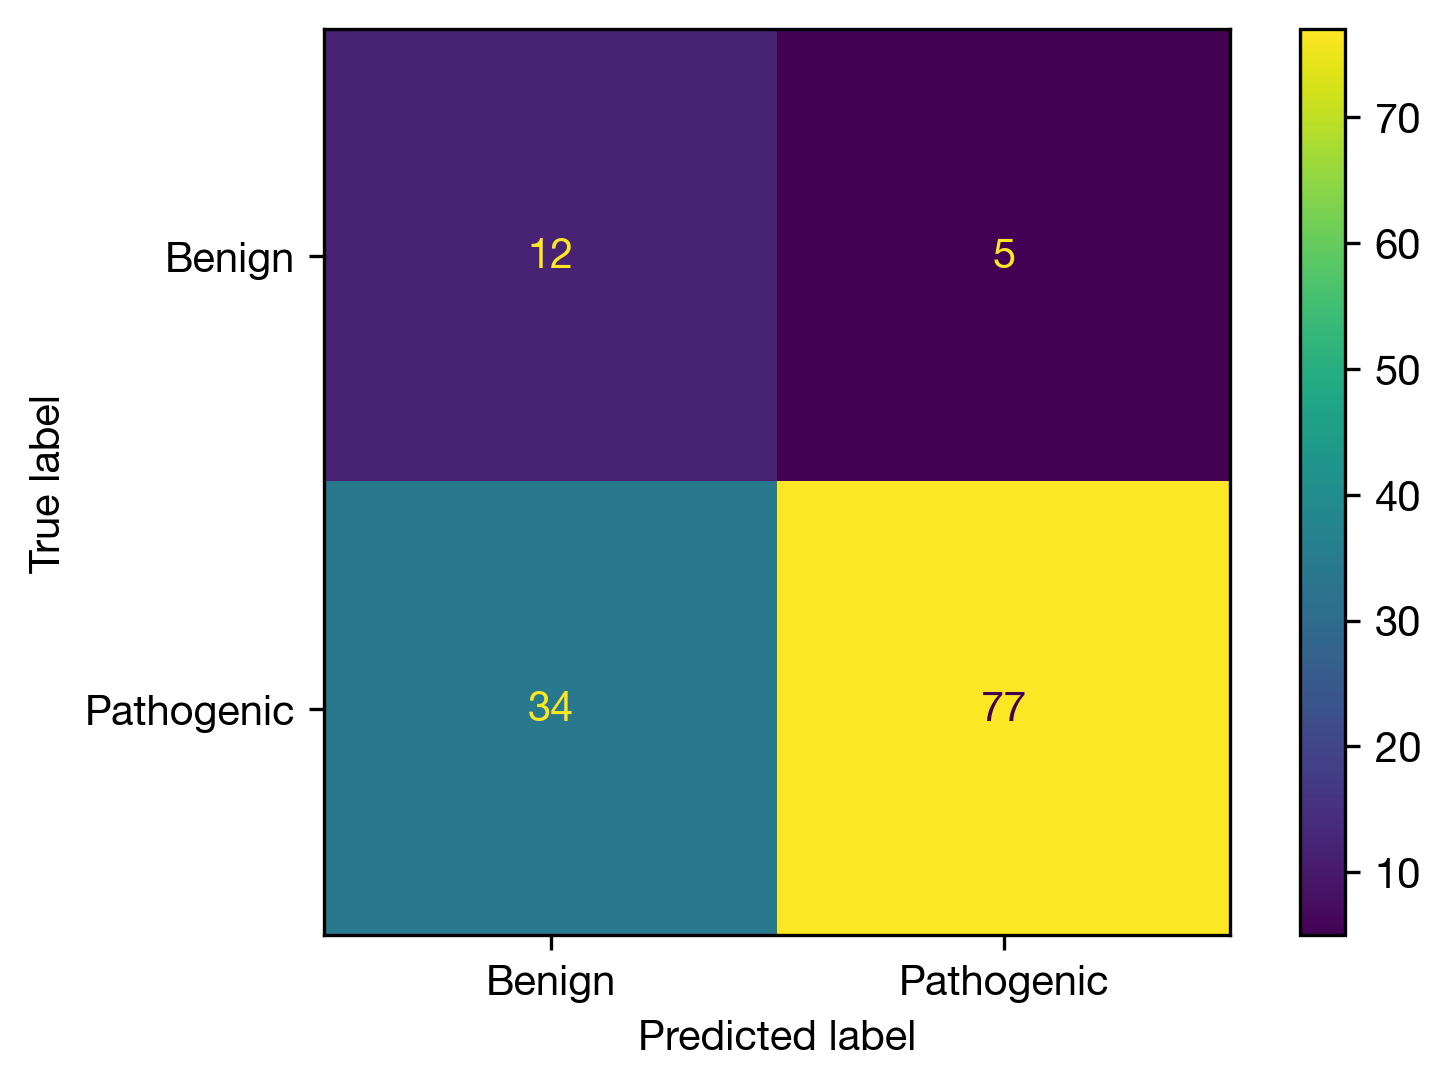

In [409]:
plot_confusion_matrix(optim_clf, X_test, y_test, display_labels = ['Benign', 'Pathogenic'])

In [1329]:
def find_best_hyperparams(inputs, outputs, n_splits, param_dict, test_size = 0.3):
    
    strat_shuffle_split = StratifiedShuffleSplit(n_splits = n_splits, test_size = test_size)
    
    pipe = Pipeline([
        ('imputer', IterativeImputer(add_indicator = True, max_iter = 100)),
        ('scaler', preprocessing.StandardScaler()),
        ('hyperparam_gridsearch', GridSearchCV(
            estimator = svm.SVC(), 
            param_grid = param_dict, 
            cv = strat_shuffle_split, 
            scoring = 'balanced_accuracy', 
            verbose = 0, 
            n_jobs = -1
        ))
    ])
    
    pipe.fit(inputs, outputs)
    model = pipe['hyperparam_gridsearch']
    hyperparam_idx = model.cv_results_['params'].index(model.best_params_)
    best_hyperparam_scores = np.array([model.cv_results_[f'split{i}_test_score'][hyperparam_idx] for i in range(n_splits)])
    
    return model.best_params_, best_hyperparam_scores

def shuffle_split_validation(inputs, outputs, n_splits, **svc_params):
    
    strat_shuffle_split = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3)
    
    pipe = Pipeline([
        ('imputer', IterativeImputer(add_indicator = True, max_iter = 100)),
        ('scaler', preprocessing.StandardScaler())    
    ])
    
    pipe.fit(inputs, outputs)
    data = pipe.transform(inputs)
    
    holder_predictions = []
    holder_probabilities = []
    holder_scores = []
    holder_true_labels = []
    
    model = svm.SVC(probability = True, **svc_params)
    
    for train_idx, test_idx in tqdm(strat_shuffle_split.split(data, outputs), total = n_splits):
        X_train, X_test, y_train, y_test = (data[train_idx], 
                                            data[test_idx], 
                                            outputs[train_idx], 
                                            outputs[test_idx])
        model.fit(X_train, y_train)
        
        predictions = model.predict(X_test)
        probabilities = model.predict_proba(X_test)
        scores = model.score(X_test, y_test)
        
        holder_predictions.append(predictions)
        holder_probabilities.append(probabilities)
        holder_scores.append(scores)
        holder_true_labels.append(y_test)
        
    return holder_predictions, holder_probabilities, holder_scores, holder_true_labels

def two_threshold_acc(t0, t1, probs, preds, trues, min_cov, rich_output = False):
    if t1<t0:
        return 0.0
    bool_array = np.logical_or(np.logical_and(probs < t0, preds==0), np.logical_and(probs > t1, preds==1))
    new_preds = preds[bool_array]
    if (len(new_preds)/len(trues)) <= min_cov:
        return -1.0
    new_trues = trues[bool_array]
    n_corr = ((new_preds * new_trues) + (1 - new_preds) * (1 - new_trues)).sum()
    if not rich_output:
        return n_corr/len(new_trues)
    else:
        new_probs = probs[bool_array]
        return n_corr/len(new_trues), new_probs, new_trues, new_preds


def get_coverage_threshold(probs, preds, trues, min_cov):
    # find threshold
    probs_sort = probs.copy()
    probs_sort.sort()
    probs_sort_roll = np.roll(probs_sort, -1)
    probs_sort_roll[-1] = 1
    possible_thresholds = (probs_sort_roll + probs_sort)/2
    indices = np.vstack(np.triu_indices(len(possible_thresholds))).T
    
    threshold_pairs = possible_thresholds[indices]

    # find the accuracy for each threshold pair
    accs = np.apply_along_axis(lambda x: two_threshold_acc(x[0], x[1], probs, preds, trues, min_cov), 1, threshold_pairs)
    max_acc_idx = np.argmax(accs)
    max_acc_thresholds = threshold_pairs[max_acc_idx]
    
    _, new_probs, new_trues, new_preds = two_threshold_acc(max_acc_thresholds[0], 
                                                max_acc_thresholds[1], 
                                                probs, preds, trues, min_cov, 
                                                rich_output = True)
    
    return accs.max(), max_acc_thresholds, new_probs, new_trues, new_preds

def score_with_rejection(holder_preds, holder_probs, holder_trues, min_coverage):
    holder_scores_with_rejection = []
    holder_new_probs = []
    holder_new_trues = []
    holder_new_preds = []
    
    for i in tqdm(range(len(holder_preds))):
        max_acc, max_acc_thresholds, new_probs, new_trues, new_preds = get_coverage_threshold(holder_probs[i][:, 1], 
                                                                                   holder_preds[i], 
                                                                                   holder_trues[i], 
                                                                                   min_coverage)
        holder_scores_with_rejection.append(max_acc)
        holder_new_probs.append(new_probs)
        holder_new_trues.append(new_trues)
        holder_new_preds.append(new_preds)
        
    return holder_scores_with_rejection, holder_new_probs, holder_new_trues, holder_new_preds

def mean_CI(data, a=0.05, N = 1000):
    # use the bootstrap to compute confidence intervals for the mean of an unkown distribution
    n = len(data)
    xbar = np.mean(data)
    bootstrap = np.random.choice(a = data, replace = True, size = (N, n))
    bootstrap_means = bootstrap.mean(axis = 1)
    bootstrap_means.sort()
    L = bootstrap_means[int(N * a/2)]
    U = bootstrap_means[int(N * (1 - a/2))]
    return L, xbar, U

def std_CI(data, a=0.05, N = 1000):
    # use the bootstrap to compute confidence intervals for the mean of an unkown distribution
    n = len(data)
    sigbar = np.std(data)
    bootstrap = np.random.choice(a = data, replace = True, size = (N, n))
    bootstrap_means = bootstrap.std(axis = 1)
    bootstrap_means.sort()
    L = bootstrap_means[int(N * a/2)]
    U = bootstrap_means[int(N * (1 - a/2))]
    return L, sigbar, U

In [1257]:
toy = np.arange(1,20, 1)

In [1258]:
np.random.choice(a = toy, replace = True, size = (1000, 30))

array([[ 4,  1,  5, ..., 17, 15,  8],
       [ 1,  9, 14, ...,  1,  3,  5],
       [ 9, 13, 19, ...,  6, 16, 16],
       ...,
       [ 5,  9, 19, ...,  8, 10,  5],
       [ 3, 10, 19, ..., 16,  2,  1],
       [ 1,  6, 18, ..., 19, 15,  3]])

In [1472]:
tuned_parameters = [{'C': [1,10,25,30,50,75,100,200], 
                        'gamma': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 10, 50, 'scale'], 
                        'kernel': ['rbf'], 'class_weight':['balanced']}, 
                        {'kernel': ['poly'], 'degree': [1,2,3,4,5,6], 'class_weight':['balanced']}]

feature_combinations=[[0,1,2,3], [1,2,3], [0,2,3], [0,1,3], [0,1,2]]
combination_names = ['all_features', 'no_pphen2', 'no_coils', 'no_structscore', 'no_mrbayes']
feat_comb_params_dict = {}

for i in tqdm(range(len(feature_combinations))):
    best_params, scores = find_best_hyperparams(inputs = input_data[:, feature_combinations[i]], 
                                              outputs = output_data, 
                                              n_splits = 300, 
                                              param_dict = tuned_parameters, 
                                              test_size = 0.3)
    
    feat_comb_params_dict[combination_names[i]] = (best_params, scores)


  0%|          | 0/5 [00:00<?, ?it/s]

In [1079]:
feat_comb_validation_dict = {}

for i in range(len(feature_combinations)):
    
    holder_predictions, holder_probabilities, holder_scores, holder_true_labels = shuffle_split_validation(inputs = input_data[:, feature_combinations[i]],  
                                                                                                        outputs = output_data, 
                                                                                                        n_splits = 500,
                                                                                                        **feat_comb_params_dict[combination_names[i]][0])
    feat_comb_validation_dict[combination_names[i]] = {'preds': holder_predictions, 
                                                       'probs': holder_probabilities, 
                                                       'scores': holder_scores, 
                                                       'trues': holder_true_labels}

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [1046]:
holder_scores_cov60, holder_probs_cov60, holder_trues_cov60 = score_with_rejection(holder_predictions, holder_probabilities, holder_true_labels, 0.6)

  0%|          | 0/300 [00:00<?, ?it/s]

In [1134]:
feat_comb_cov60_dict = {}

for i in range(len(feature_combinations)):
    
    holder_scores, holder_probabilities, holder_true_labels, _ = score_with_rejection(holder_preds = feat_comb_validation_dict[combination_names[i]]['preds'], 
                                                                                   holder_probs = feat_comb_validation_dict[combination_names[i]]['probs'], 
                                                                                   holder_trues = feat_comb_validation_dict[combination_names[i]]['trues'], 
                                                                                   min_coverage = 0.6)
    feat_comb_cov60_dict[combination_names[i]] = {'probs': holder_probabilities, 
                                                  'scores': holder_scores, 
                                                  'trues': holder_true_labels}




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

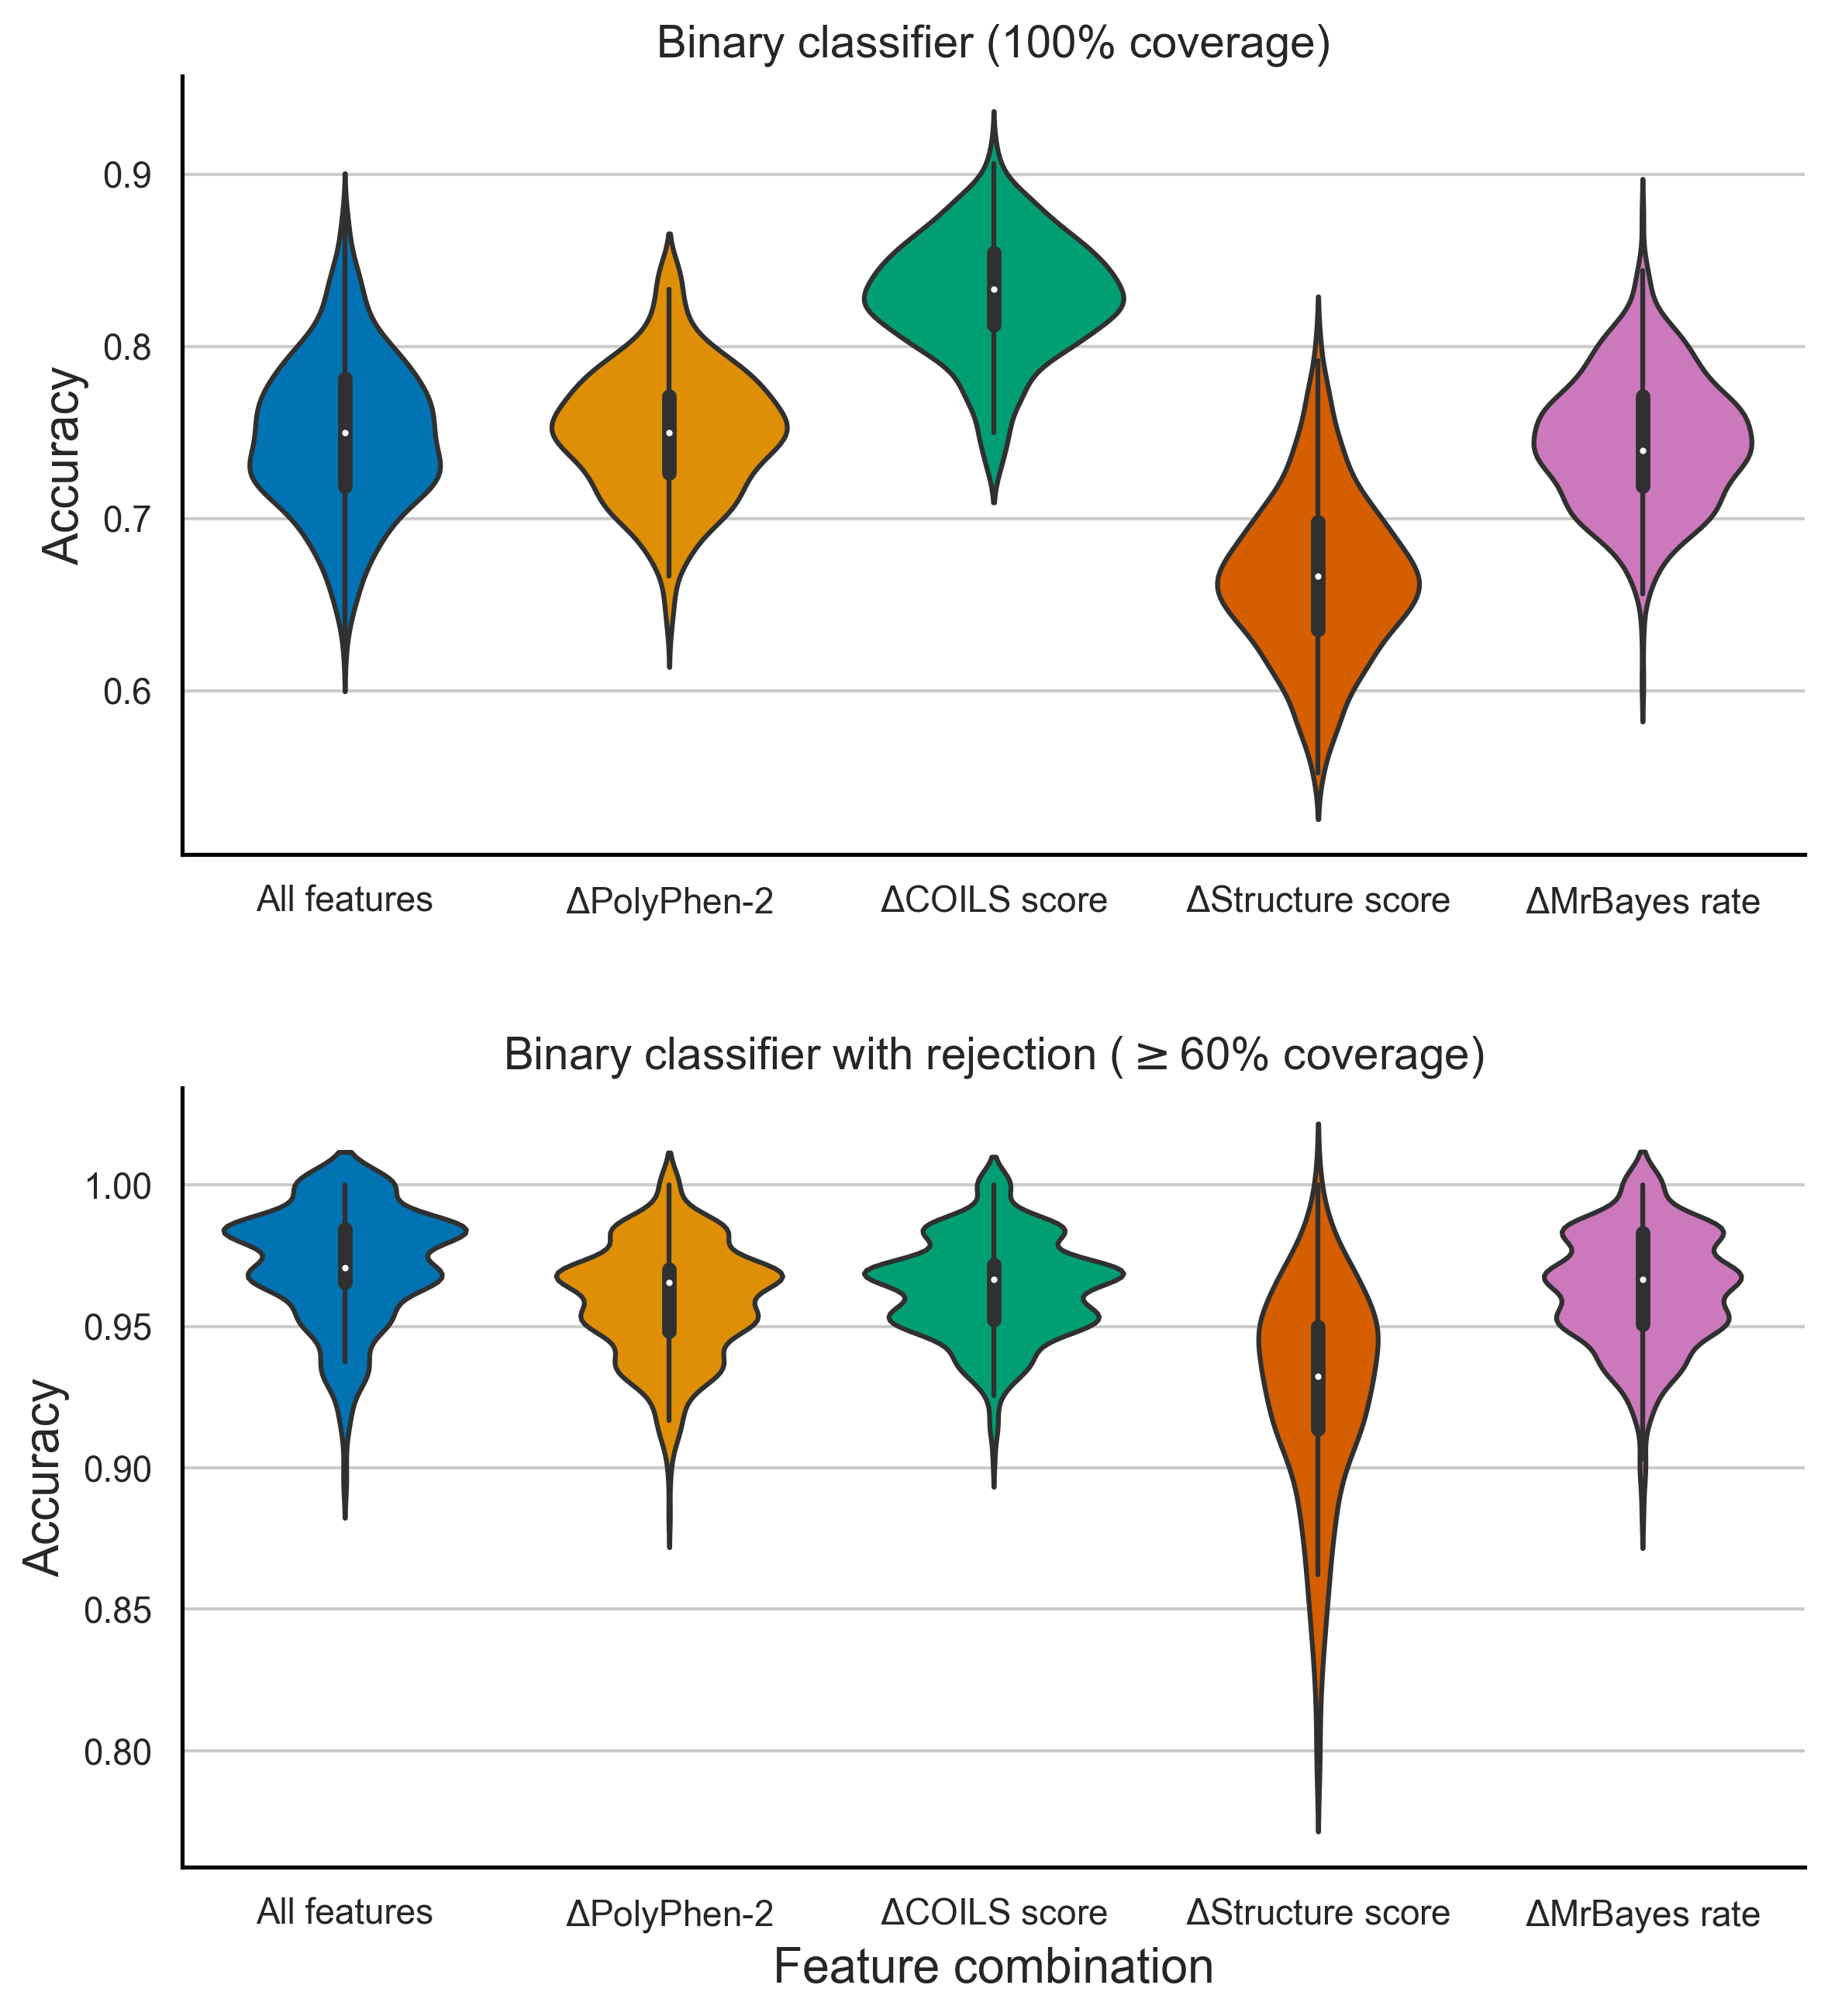

In [1433]:
fig, axes = plt.subplots(2,1, figsize = (9, 10))


df = pd.DataFrame([feat_comb_validation_dict[c]['scores'] for c in combination_names]).T
df.columns = combination_names
df = df.melt(value_vars = combination_names)

ax = axes[0]
sns.set_theme(style="whitegrid")
sns.violinplot(data = df, x = 'variable', y = 'value', ax = ax, inner='box', saturation = 1, palette = sns.color_palette("colorblind"))
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_xticklabels(['All features', '$\Delta$PolyPhen-2', '$\Delta$COILS score', '$\Delta$Structure score', '$\Delta$MrBayes rate']);
sns.despine()
ax.set_xlabel('')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_title('Binary classifier (100% coverage)', fontsize = 14)


df = pd.DataFrame([feat_comb_cov60_dict[c]['scores'] for c in combination_names]).T
df.columns = combination_names
df = df.melt(value_vars = combination_names)
ax = axes[1]
sns.set_theme(style="whitegrid")
sns.violinplot(data = df, x = 'variable', y = 'value', ax = ax, inner='box', saturation = 1, palette = sns.color_palette("colorblind"))
ax.set_xlabel('Feature combination', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_xticklabels(['All features', '$\Delta$PolyPhen-2', '$\Delta$COILS score', '$\Delta$Structure score', '$\Delta$MrBayes rate']);
sns.despine()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_title('Binary classifier with rejection ($\geq$60% coverage)', fontsize = 14)


fig.subplots_adjust(hspace = 0.3)
fig.savefig('accuracy_plots.png')

In [1331]:
coverages = [0.9, 0.8, 0.7, 0.6]
coverage_perf_dict = {}


for cov in coverages:
    
    holder_scores, holder_probabilities, holder_true_labels, holder_predictions = score_with_rejection(
                                                                                   holder_preds = feat_comb_validation_dict['all_features']['preds'], 
                                                                                   holder_probs = feat_comb_validation_dict['all_features']['probs'], 
                                                                                   holder_trues = feat_comb_validation_dict['all_features']['trues'], 
                                                                                   min_coverage = cov)
    coverage_perf_dict[cov] = {'probs': holder_probabilities, 
                              'scores': holder_scores, 
                              'trues': holder_true_labels,
                              'preds': holder_predictions}

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [1356]:
len(feat_comb_validation_dict['all_features']['preds'][0])

96

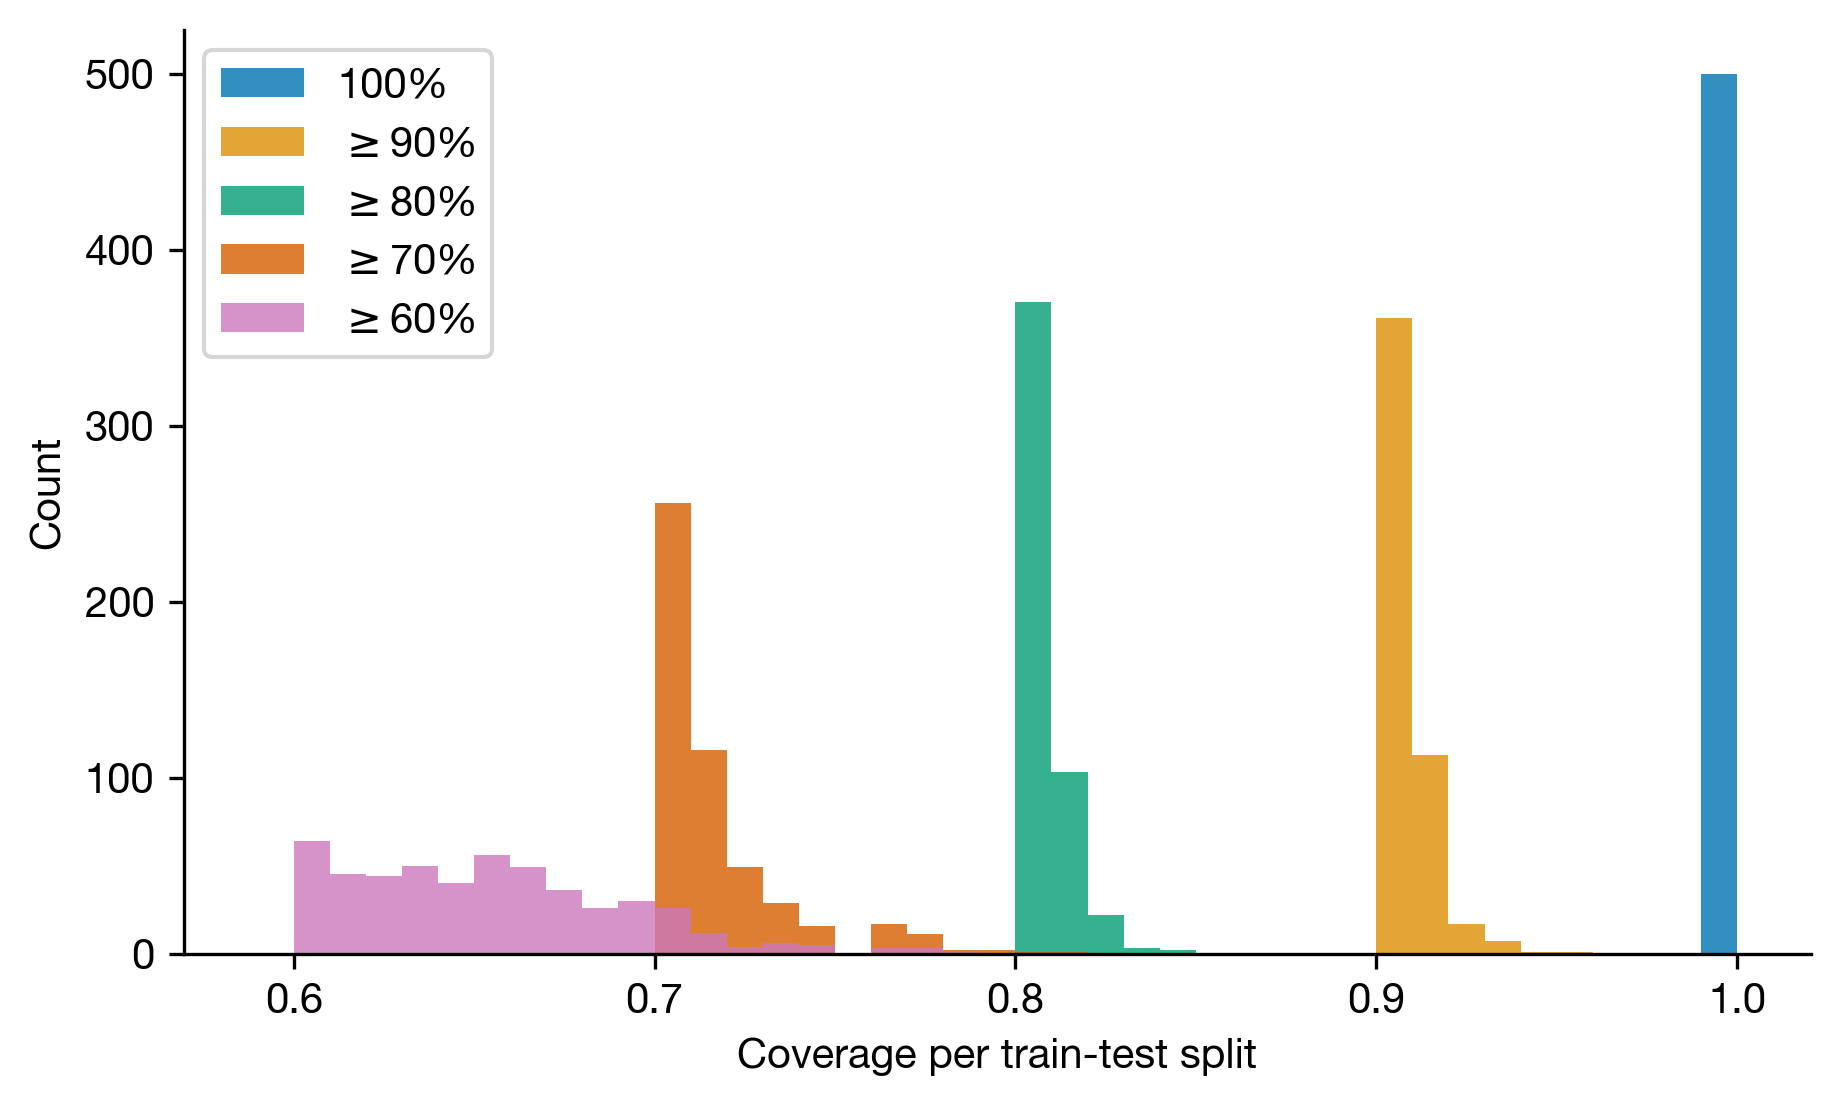

In [1449]:
fig, ax = plt.subplots(figsize = (7, 4))

    

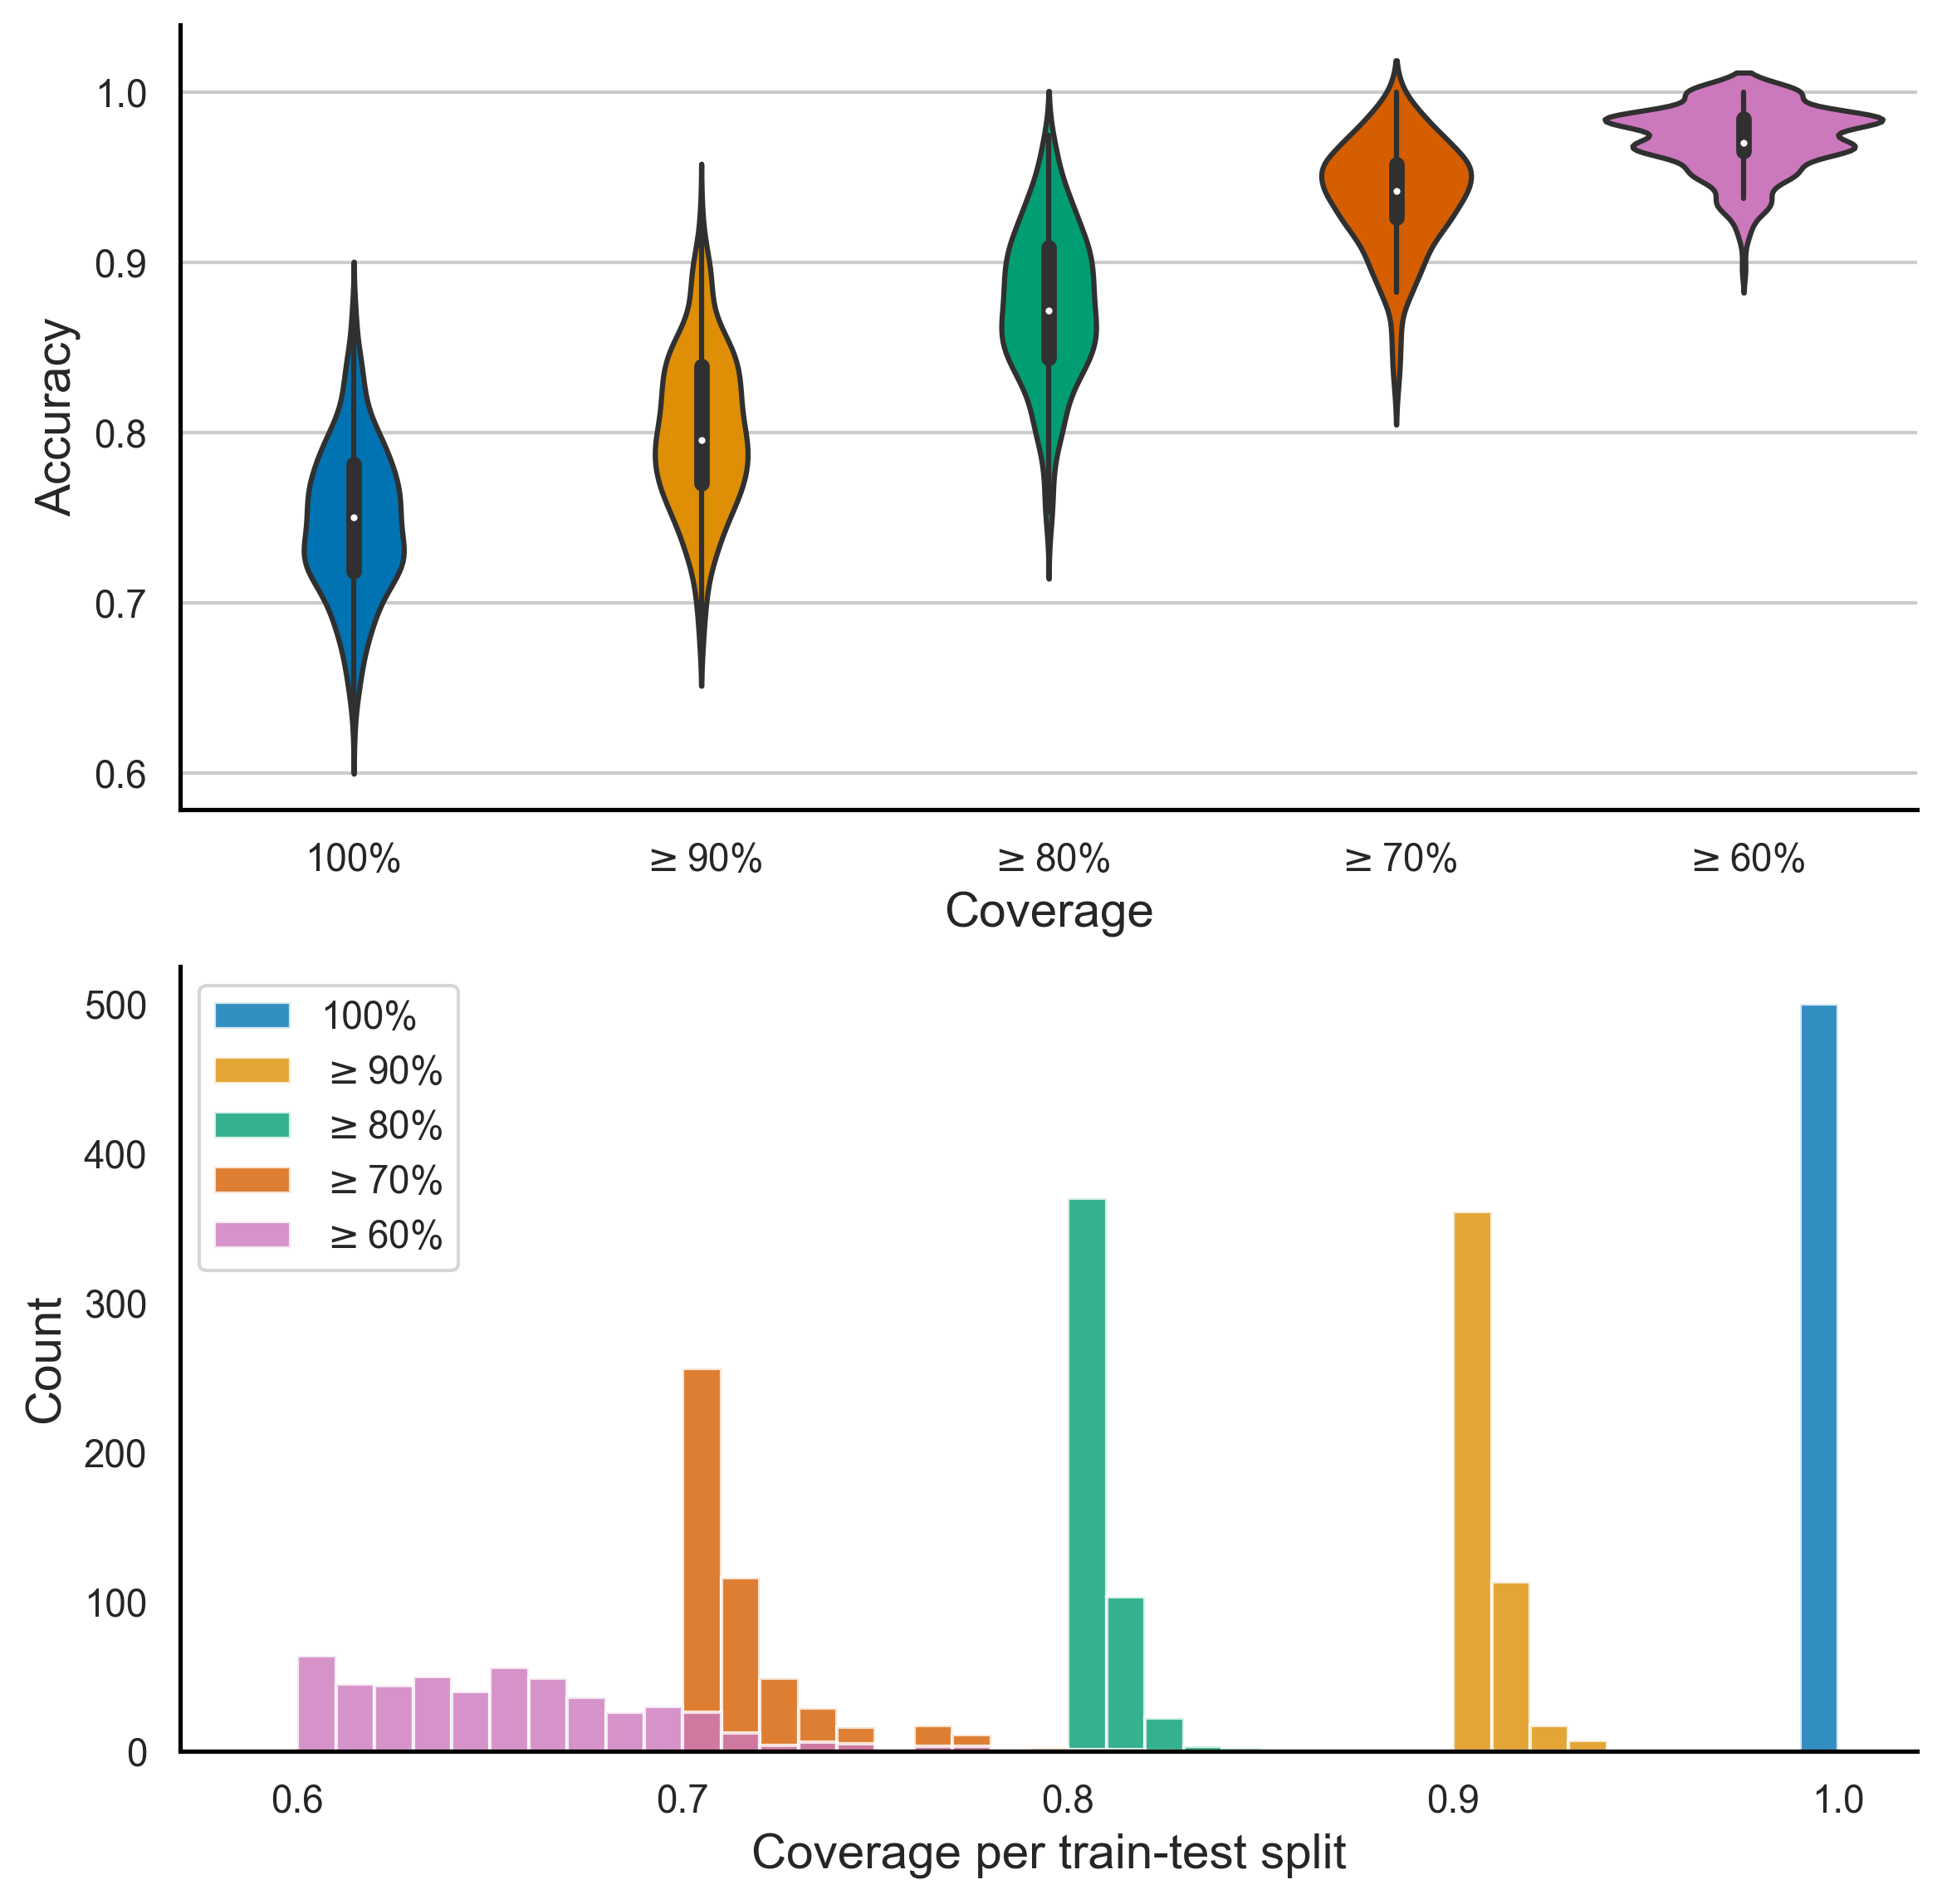

In [1461]:
df = pd.DataFrame([feat_comb_validation_dict['all_features']['scores']]+[coverage_perf_dict[cov]['scores'] for cov in coverages]).T
df = df.melt(value_vars = df.columns)

fig, axes = plt.subplots(2, 1, figsize = (9, 9))

ax = axes[0]
sns.set_theme(style="whitegrid")
sns.violinplot(data = df, x = 'variable', y = 'value', ax = ax, inner='box', saturation = 1, palette = sns.color_palette("colorblind"))
ax.set_ylabel('Accuracy', fontsize = 14)
ax.set_xticklabels(['100%', '$\geq$90%', '$\geq$80%', '$\geq$70%', '$\geq$60%']);
sns.despine()
ax.set_xlabel('Coverage', fontsize = 14)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# reset_plot_style()
ax = axes[1]
palette = itertools.cycle(sns.color_palette('colorblind'))

full_cov = np.array([len(x) for x in feat_comb_validation_dict['all_features']['preds']])/96
ax.hist(full_cov, bins = np.arange(0.59, 1.01, 0.01), alpha = 0.8, color = next(palette))

for cov in coverages:
    actual_cov = np.array([len(x) for x in coverage_perf_dict[cov]['preds']])/96
    ax.hist(actual_cov, bins = np.arange(0.59, 1, 0.01), alpha = 0.8, color = next(palette))
ax.set_xlabel('Coverage per train-test split', fontsize = 14)
ax.set_ylabel('Count', fontsize = 14)
ax.legend(['100%']+['$\geq$%i%%' % (cov*100) for cov in coverages])
sns.despine()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(False)

fig.savefig('decreasing_cov.png')


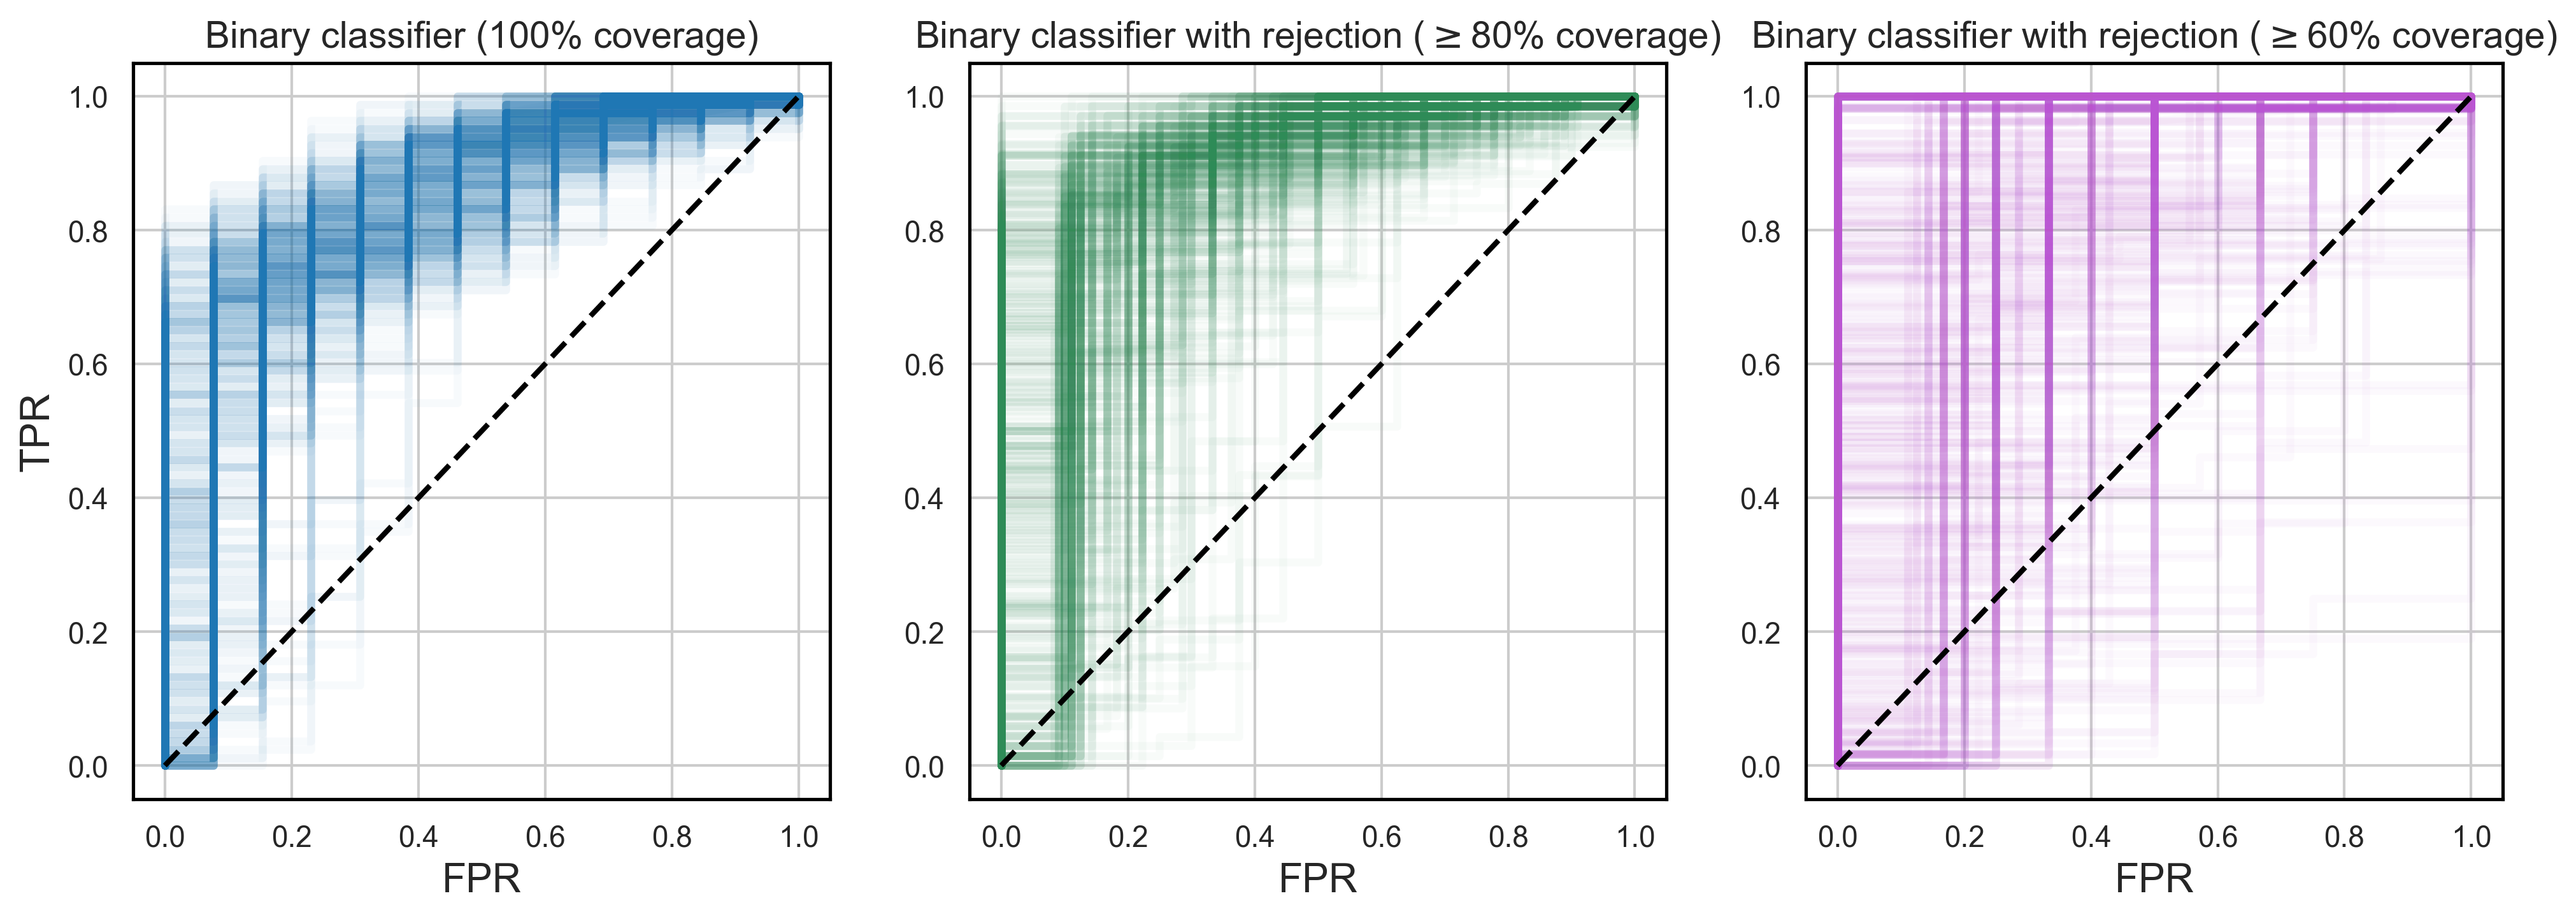

In [1458]:
fig, ax = plt.subplots(1,3, figsize = (16,5))

holder_aucs = []

for i in range(len(feat_comb_validation_dict['all_features']['trues'])):
    fpr, tpr, _ = roc_curve(feat_comb_validation_dict['all_features']['trues'][i], 
                            feat_comb_validation_dict['all_features']['probs'][i][:, 1], 
                            pos_label = 1)
    holder_aucs.append(auc(fpr, tpr))
    ax[0].plot(fpr, tpr, alpha = 0.03, c = 'tab:blue', lw = 3)
ax[0].set_ylabel('TPR', fontsize = 15)
ax[0].set_xlabel('FPR', fontsize = 15)
ax[0].set_title('Binary classifier (100% coverage)', fontsize = 14)
ax[0].grid(True)
ax[0].plot([0,1], [0,1], lw = 2, linestyle ='dashed', c = 'black')


holder_aucs_cov80 = []
for i in range(len(coverage_perf_dict[0.8]['scores'])):
    fpr, tpr, _ = roc_curve(coverage_perf_dict[0.8]['trues'][i], 
                            coverage_perf_dict[0.8]['probs'][i], 
                            pos_label = 1)
    ax[1].plot(fpr, tpr, alpha = 0.03, c = 'seagreen', lw = 3)
    holder_aucs_cov80.append(auc(fpr, tpr))
ax[1].set_xlabel('FPR', fontsize = 15)
ax[1].plot([0,1], [0,1], lw = 2, linestyle ='dashed', c = 'black')
ax[1].set_title('Binary classifier with rejection ($\geq$80% coverage)', fontsize = 14)


holder_aucs_cov60 = []
for i in range(len(feat_comb_cov60_dict['all_features']['trues'])):
    fpr, tpr, _ = roc_curve(feat_comb_cov60_dict['all_features']['trues'][i], 
                            feat_comb_cov60_dict['all_features']['probs'][i], 
                            pos_label = 1)
    ax[2].plot(fpr, tpr, alpha = 0.03, c = 'mediumorchid', lw = 3)
    holder_aucs_cov60.append(auc(fpr, tpr))
ax[2].set_xlabel('FPR', fontsize = 15)
ax[2].plot([0,1], [0,1], lw = 2, linestyle ='dashed', c = 'black')
ax[2].set_title('Binary classifier with rejection ($\geq$60% coverage)', fontsize = 14)



ax[1].grid(True)
ax[2].grid(True)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].spines['right'].set_color('black')
ax[0].spines['top'].set_color('black')
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].spines['right'].set_color('black')
ax[1].spines['top'].set_color('black')
ax[2].spines['bottom'].set_color('black')
ax[2].spines['left'].set_color('black')
ax[2].spines['right'].set_color('black')
ax[2].spines['top'].set_color('black')

fig.savefig('rocs.png')

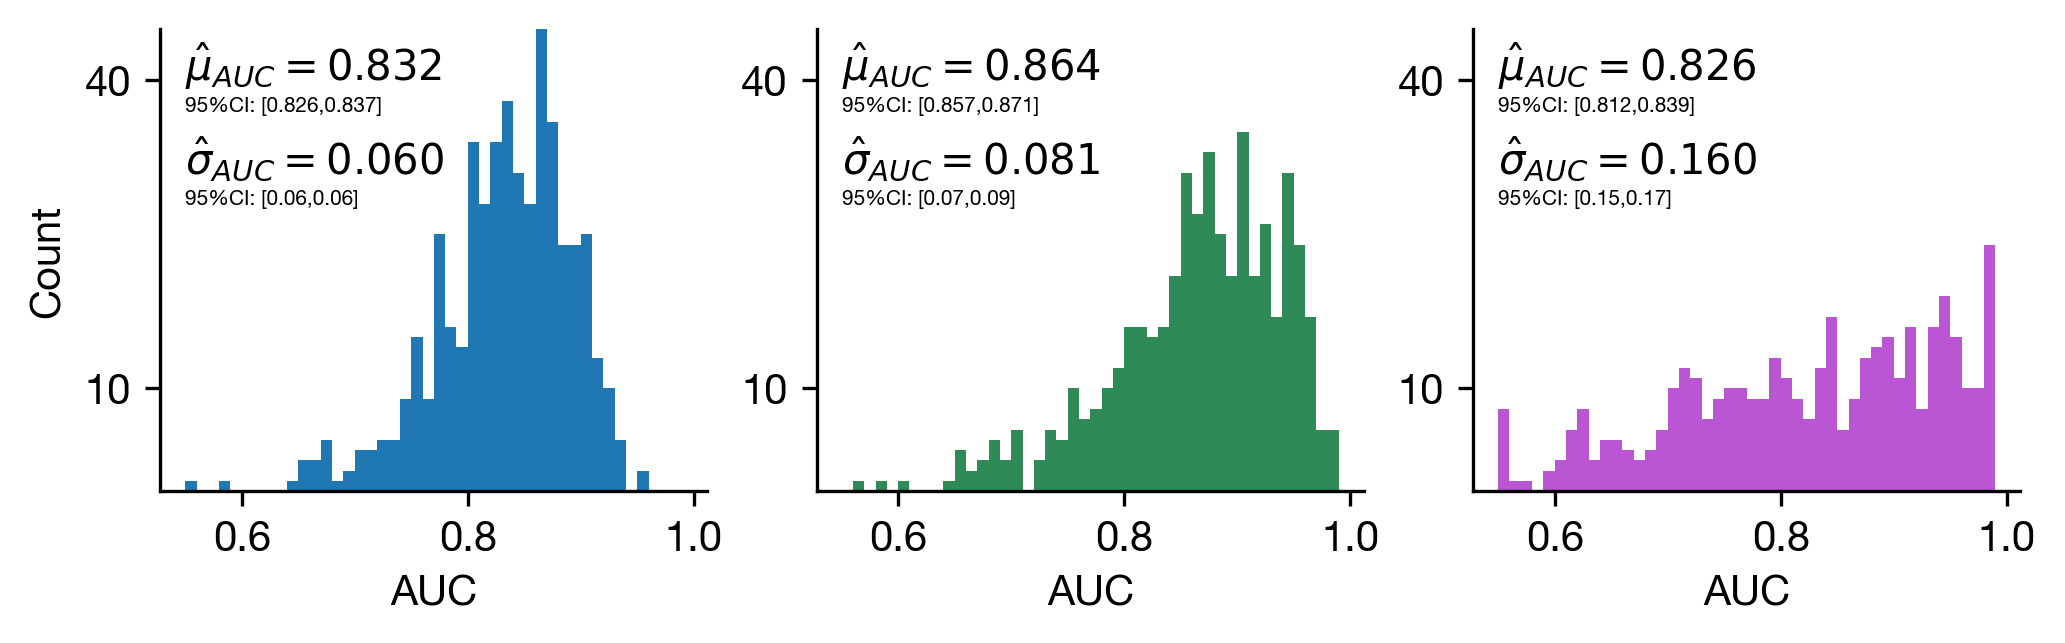

In [1439]:
reset_plot_style()

fig, axes = plt.subplots(1,3, figsize = (8, 2))

ax = axes[0]
ax.hist(holder_aucs, bins = np.arange(0.55, 1, 0.01), color = 'tab:blue');
# ax.set_xlabel('AUC')
ax.set_ylabel('Count')
ax.set_xlabel('AUC')
ax.set_yticks([10, 40])
ax.set_yticklabels([10, 40])
ax.set_ylim([0, 45])
sns.despine()
l, mu, u = mean_CI(holder_aucs)
ax.text(0.55, 40, '$\hat{\mu}_{AUC}=%.3f$' % mu)
ax.text(0.55, 37, '95%%CI: [%.3f,%.3f]' % (l, u), fontsize = 5)

l, sig, u = std_CI(holder_aucs)
ax.text(0.55, 31, '$\hat{\sigma}_{AUC}=%.3f$' % sig)
ax.text(0.55, 28, '95%%CI: [%.2f,%.2f]' % (l, u), fontsize = 5)

holder_aucs_cov80 = np.array(holder_aucs_cov80)[~np.isnan(holder_aucs_cov80)] # there was a nan once
ax = axes[1]
ax.hist(holder_aucs_cov80, bins = np.arange(0.55, 1, 0.01), color = 'seagreen');
ax.set_xlabel('AUC')
ax.set_ylim([0, 45])
ax.set_yticks([10, 40])
ax.set_yticklabels([10, 40])
sns.despine()
l, mu, u = mean_CI(holder_aucs_cov80)
ax.text(0.55, 40, '$\hat{\mu}_{AUC}=%.3f$' % mu)
ax.text(0.55, 37, '95%%CI: [%.3f,%.3f]' % (l, u), fontsize = 5)

l, sig, u = std_CI(holder_aucs_cov80)
ax.text(0.55, 31, '$\hat{\sigma}_{AUC}=%.3f$' % sig)
ax.text(0.55, 28, '95%%CI: [%.2f,%.2f]' % (l, u), fontsize = 5);



holder_aucs_cov60 = np.array(holder_aucs_cov60)[~np.isnan(holder_aucs_cov60)] # there was a nan once
ax = axes[2]
ax.hist(holder_aucs_cov60, bins = np.arange(0.55, 1, 0.01), color = 'mediumorchid');
# ax.set_xlabel('AUC')
ax.set_ylim([0, 45])
ax.set_xlabel('AUC')
ax.set_yticks([10, 40])
ax.set_yticklabels([10, 40])
sns.despine()
l, mu, u = mean_CI(holder_aucs_cov60)
ax.text(0.55, 40, '$\hat{\mu}_{AUC}=%.3f$' % mu)
ax.text(0.55, 37, '95%%CI: [%.3f,%.3f]' % (l, u), fontsize = 5)

l, sig, u = std_CI(holder_aucs_cov60)
ax.text(0.55, 31, '$\hat{\sigma}_{AUC}=%.3f$' % sig)
ax.text(0.55, 28, '95%%CI: [%.2f,%.2f]' % (l, u), fontsize = 5);



fig.savefig('aucs_2.png')

In [ ]:
def hist_confusion_matrix(preds, trues, color, saveas):
    meta_conf_matrix = np.dstack([confusion_matrix(trues[i], preds[i], normalize = 'true') for i in range(len(preds))])
    fig, axes = plt.subplots(2,2, figsize = (4,4))
    for i in range(2):
        for j in range(2):
            ax = axes[i,j]
            ax.hist(meta_conf_matrix[i, j, :],
                    color = color, 
                    alpha = 0.55)
            ax.set_xlim([0, 1])
            ax.set_xticks([0, 0.5, 1])
            ax.set_xticklabels([0, None, 1])
            ax.set_yticks([])
            sns.despine(left = True)
            ax.text(np.mean(ax.get_xlim()), 
                    np.mean(ax.get_ylim()), 
                    "%.2f" % meta_conf_matrix[i, j, :].mean(), 
                    ha = 'center', va = 'center', fontsize = 30)
    fig.savefig(saveas)

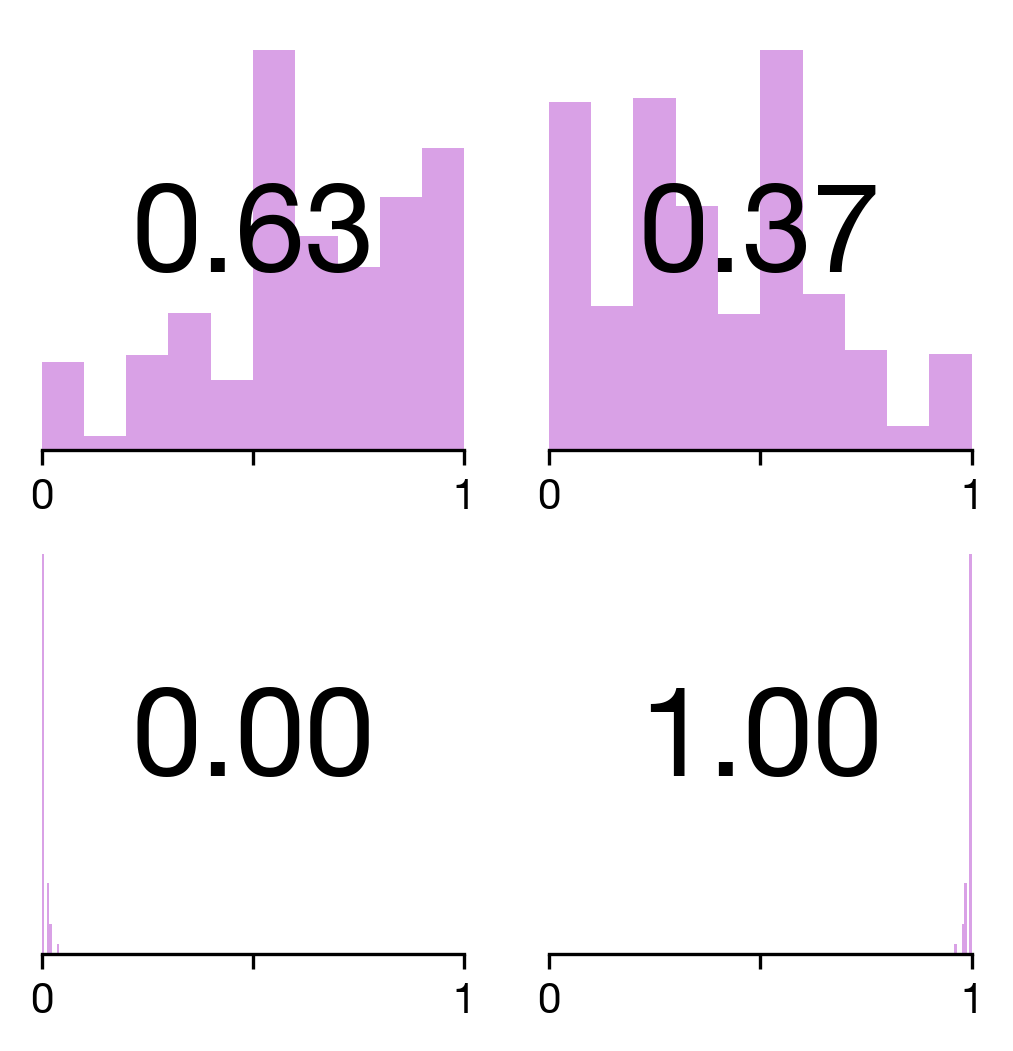

In [1431]:
preds = coverage_perf_dict[0.6]['preds']
trues = coverage_perf_dict[0.6]['trues']
hist_confusion_matrix(preds, trues, "mediumorchid", 'cov60_conf.png')

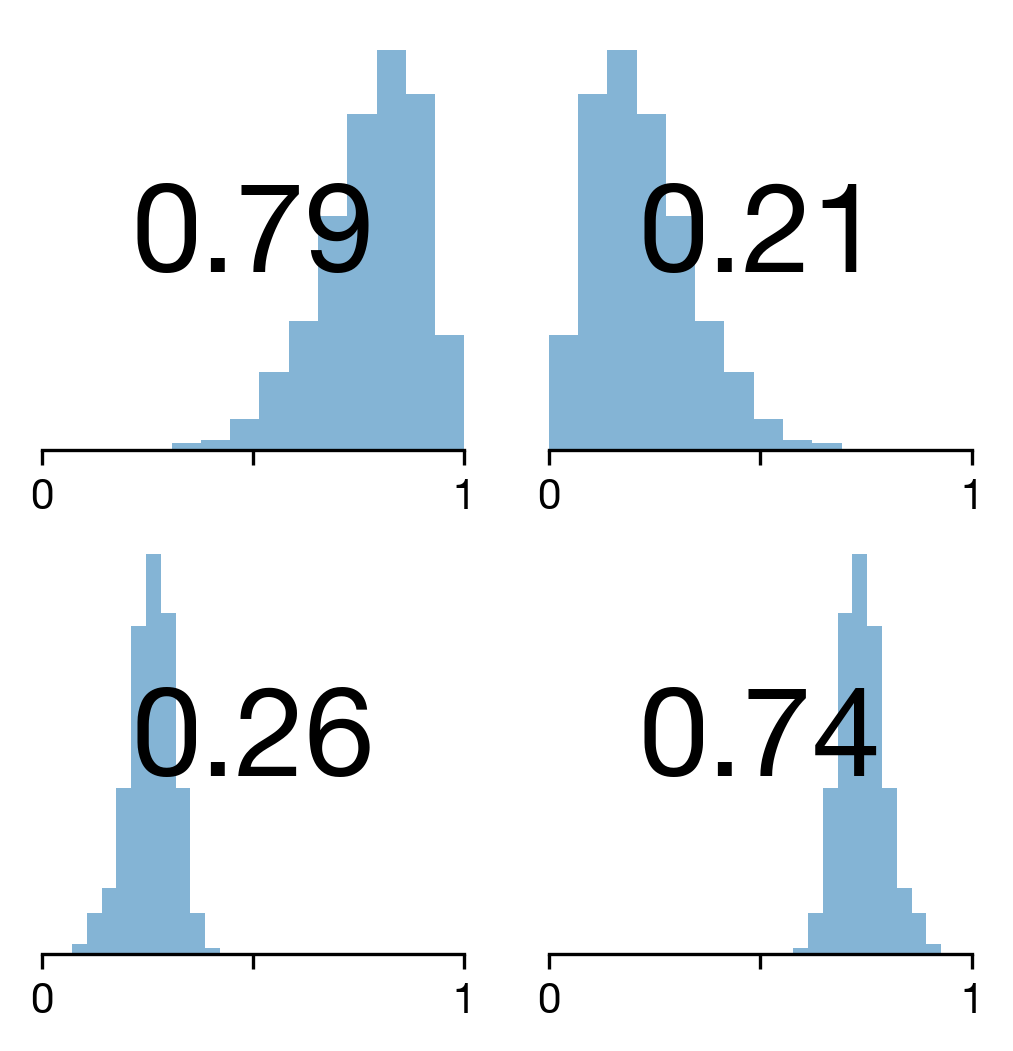

In [1430]:
preds = feat_comb_validation_dict['all_features']['preds']
trues = feat_comb_validation_dict['all_features']['trues']
hist_confusion_matrix(preds, trues, "tab:blue", 'cov100_conf.png')

## Visualizing classifiers

In [609]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1/2, x.max() + 1/2
    y_min, y_max = y.min() - 1/2, y.max() + 1/2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

best_acc = 0
best_model = None
accs = []

for n in tqdm(range(100)):
    X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(pca_input, 
                                                        output_data,
                                                        test_size = 0.3, 
                                                        shuffle = True, 
                                                        stratify = output_data)

    tuned_parameters = [{'C': [1,10,50,100,200,500,1000], 
                        'gamma': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 10, 50, 'scale'], 
                        'kernel': ['rbf'], 'class_weight':['balanced']}, 
                        {'kernel': ['poly'], 'degree': [1,2,3,4,5,6], 'class_weight':['balanced']}]

    optim_clf_2d = GridSearchCV(
        svm.SVC(), tuned_parameters, cv = 5, scoring = 'balanced_accuracy', verbose = 0, n_jobs = -1
    )

    optim_clf_2d.fit(X_train_2d, y_train_2d)
    acc = optim_clf_2d.score(X_test_2d, y_test_2d)
    if acc > best_acc:
        best_acc = acc
        best_model = optim_clf_2d
    accs.append(acc)

        

  0%|          | 0/100 [00:00<?, ?it/s]

0.7460611677479148 0
0.8072289156626506 0.7460611677479148
0.8109360518999074 0.8072289156626506
0.8531047265987025 0.8109360518999074
0.8855421686746988 0.8531047265987025


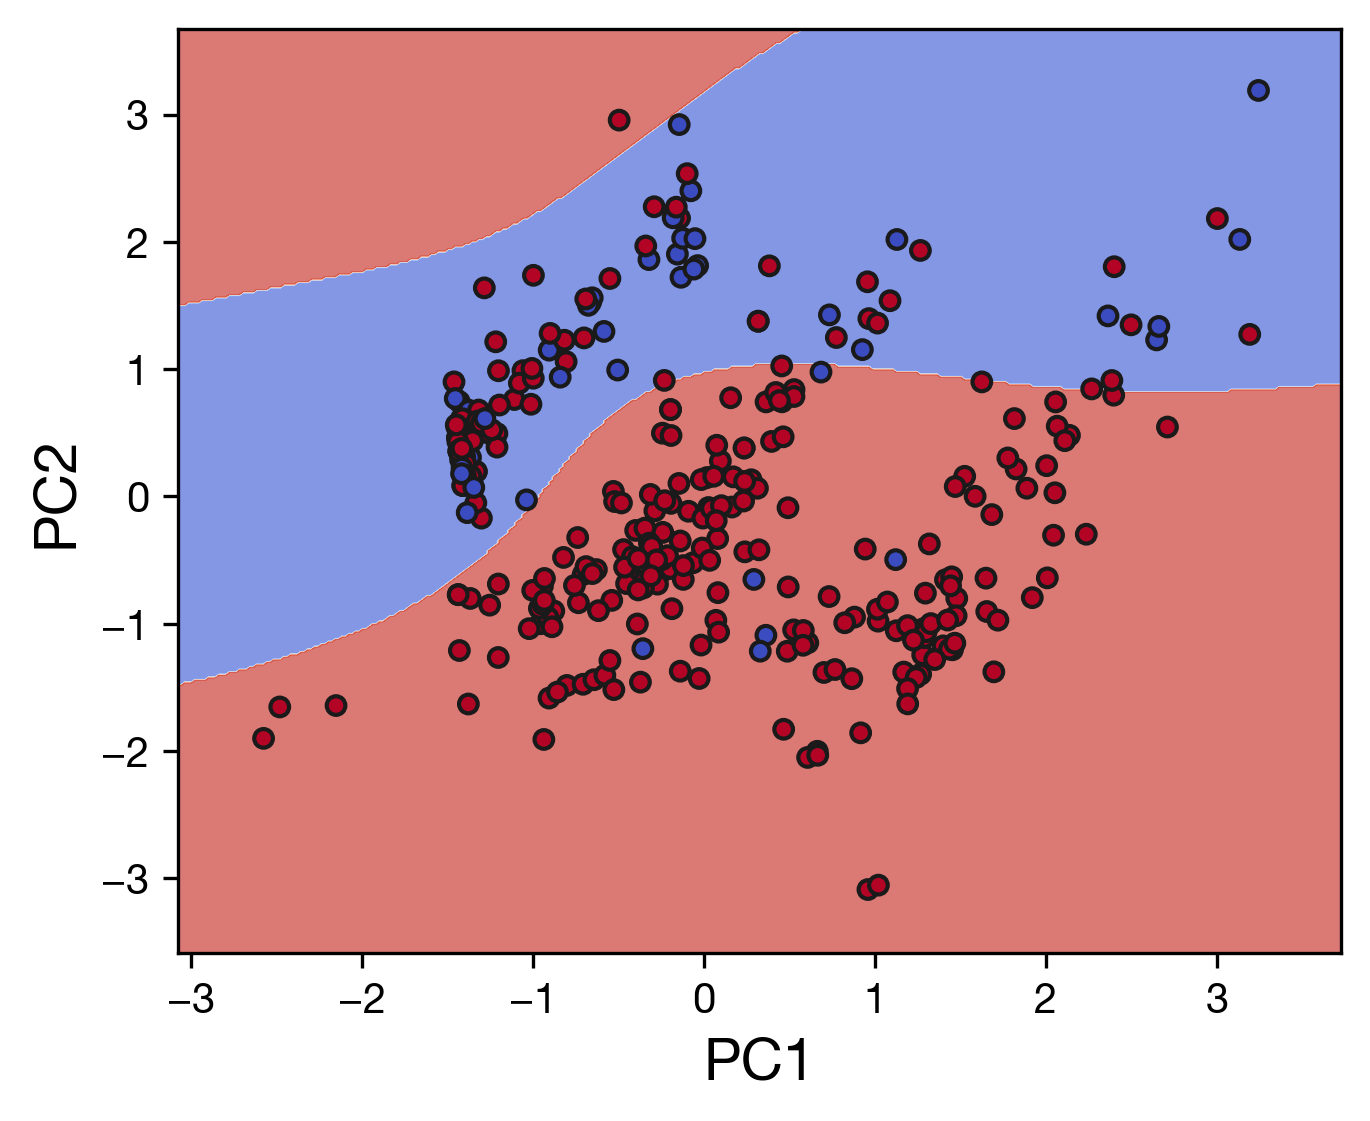

In [1470]:
reset_plot_style()


fig, ax = plt.subplots(figsize = (5, 4))
# title for the plots
title = ('RBF SVC decision boundary')

# Set-up grid for plotting.
xx, yy = make_meshgrid(pca_input[:, 0], pca_input[:, 1])

# plot
plot_contours(ax, best_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.7)
ax.scatter(pca_input[:, 0], pca_input[:, 1], c=output_data, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2', fontsize = 14)
ax.set_xlabel('PC1', fontsize = 14)

# ax.set_title(title)
plt.show()
fig.savefig('example_2d_fit.png')

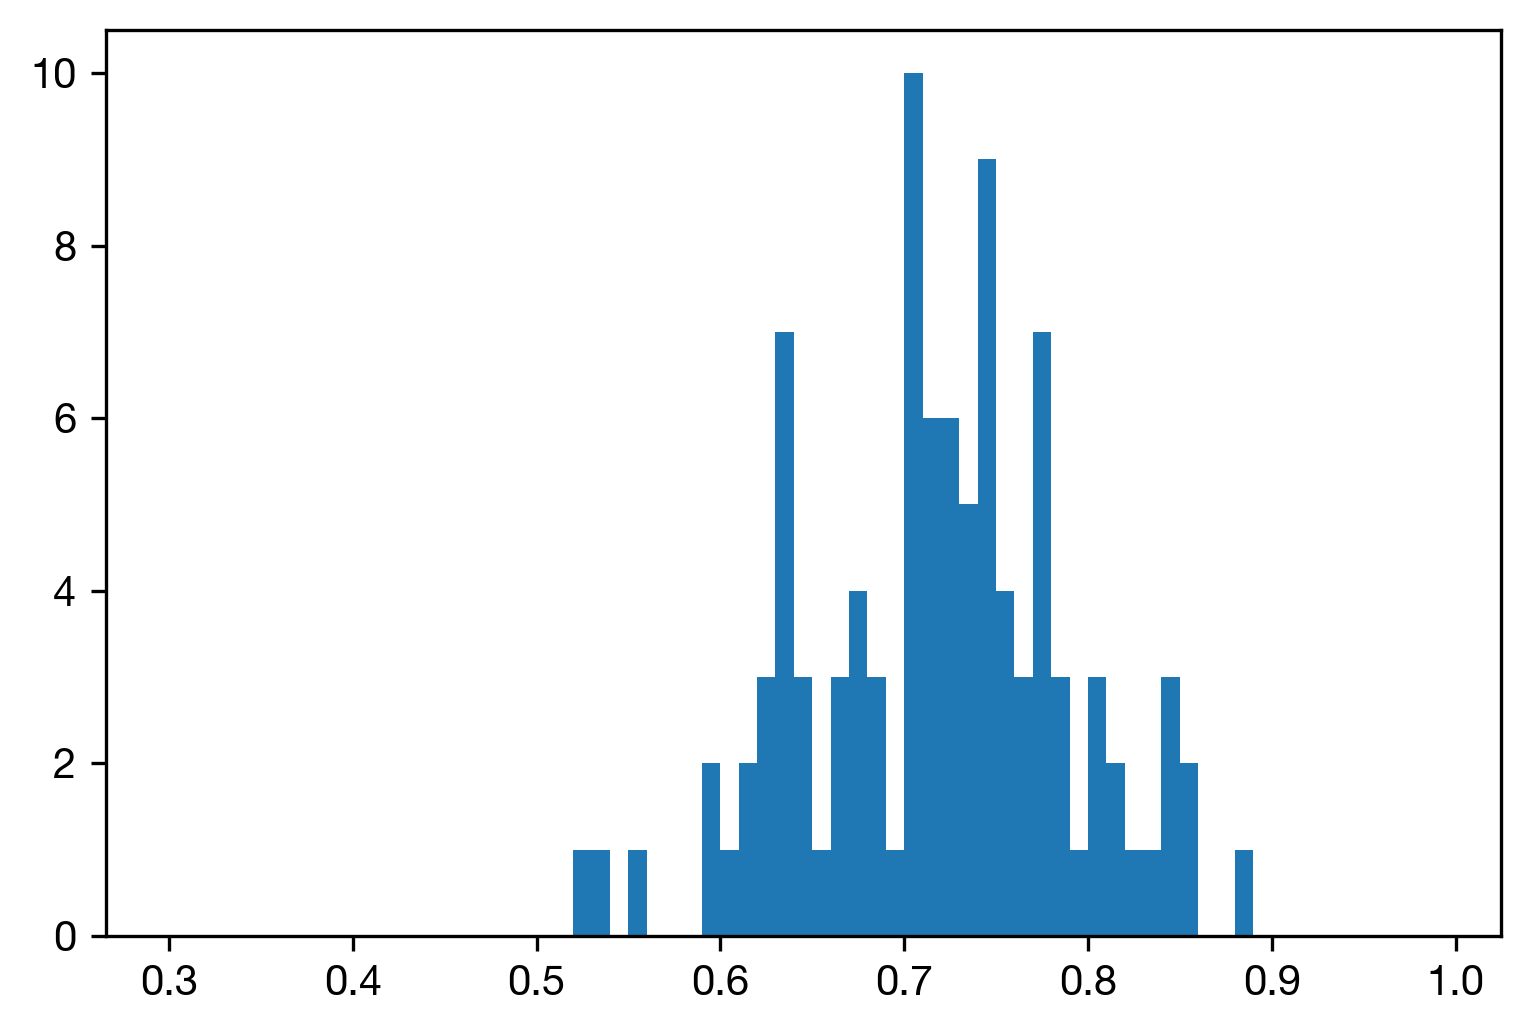

In [614]:
plt.hist(accs, bins = np.arange(0.3, 1, 0.01));

In [615]:
y_true, y_pred = y_test_2d, best_model.predict(X_test_2d)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.31      0.77      0.44        13
         1.0       0.95      0.73      0.83        83

    accuracy                           0.74        96
   macro avg       0.63      0.75      0.64        96
weighted avg       0.87      0.74      0.78        96



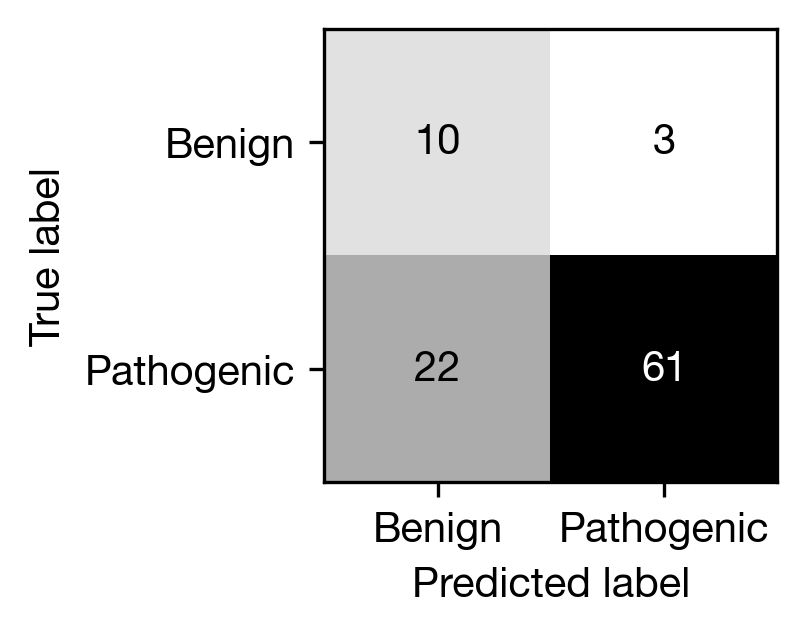

In [616]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_confusion_matrix(estimator = best_model, 
                      X = X_test_2d, 
                      y_true = y_test_2d, 
                      display_labels = ['Benign', 'Pathogenic'], 
                      normalize = None, colorbar = False, cmap = 'binary', ax = ax)

In [618]:
best_model.best_params_

{'C': 50, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}